<a href="https://colab.research.google.com/github/vmartinezalvarez/Image-generation-GAN-vs-DCGAN/blob/master/Project_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network

## What are GANs?

The idea behind GANs is that you have two networks, a generator  $G$  and a discriminator  $D$, competing against each other. The generator makes fake data to pass to the discriminator. The discriminator also sees real data and predicts whether the data it receives is real or false. The generator is trained to fool the discriminator, it wants to output data that looks as close as possible to real data. And the discriminator is trained to figure out which data is real and which is fake. What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.







### Import TensorFlow and other libraries

In [0]:
from __future__ import absolute_import, division, print_function

In [2]:
!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

    100% |████████████████████████████████| 332.1MB 82kB/s 
    100% |████████████████████████████████| 61kB 23.9MB/s 
    100% |████████████████████████████████| 3.0MB 8.6MB/s 
    100% |████████████████████████████████| 419kB 12.4MB/s 


In [3]:
# To generate GIFs
!pip install imageio

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow.keras.layers as layers
import time

from IPython import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Load and prepare the MNIST dataset to train the generator and the discriminator.



In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
train_images = train_images.reshape(train_images.shape[0],-1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_images.shape[0]
train_images.shape

(60000, 784)

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models
### The Generator


In [0]:
def make_generator_model():
  
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(256, use_bias=True, input_shape=(100,)))
    model.add(layers.LeakyReLU())
 
    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(1024, use_bias=True))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(784, use_bias=True, activation='tanh'))
  
    return model

In [29]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# print(generated_image.shape)

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 784)              

### The Discriminator


In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(1024, use_bias=True, input_shape=(784,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(256, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))
     
    return model

In [31]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

discriminator.summary()

tf.Tensor([[-0.1486974]], shape=(1, 1), dtype=float32)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the disciminators decisions on the generated images to an array of 1s.

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints


In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop



In [0]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 25

seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):  
  for epoch in range(epochs):
    start = time.time()
    
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**



In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False. 
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(5,5))
  
  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      imagen = predictions[i].numpy().reshape((28,28))
      plt.imshow(imagen * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
        
  label = 'Epoch {0}'.format(epoch)
  fig.text(0.51, 0.05, label, ha='center',fontsize=14)
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously.

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. 

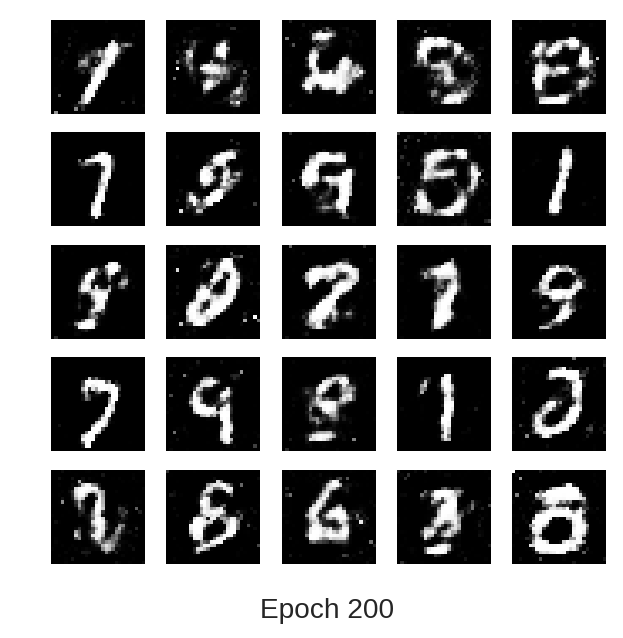

CPU times: user 13min 38s, sys: 2min 30s, total: 16min 8s
Wall time: 15min 48s


In [45]:
%%time
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [46]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

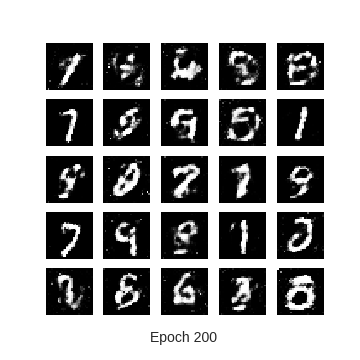

In [48]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [0]:
with imageio.get_writer('gan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# A hack to display the GIF inside this notebook
os.rename('gan.gif', 'gan.gif.png')

Display the animated gif with all the mages generated during the training of GANs.

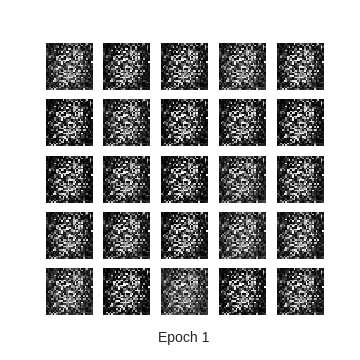

In [50]:
display.Image(filename="gan.gif.png")